In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Загрузка данных
# Оригинальный набор данных доступен для скачивания по ссылке https://www.sberbank.com/ru/analytics/opendata
data = pd.read_csv('http://sbrfdata.ru/opendata.zip', encoding="cp1251", parse_dates=['date'], dayfirst=False)

### Задание №1

Создать приложение, которое будет из готового файла с данными «Сбербанка» (https://www.sberbank.com/ru/analytics/opendata) выводить результат по параметрам:
 тип данных;
 интервал дат;
 область.

### Задание №2

Визуализировать выводимые данные с помощью графика

In [2]:
data.head()

,name,region,date,value
0,Количество заявок на потребительские кредиты,Россия,2013-01-15,571147
1,Количество заявок на потребительские кредиты,Россия,2013-02-15,504508
2,Количество заявок на потребительские кредиты,Россия,2013-03-15,628803
3,Количество заявок на потребительские кредиты,Россия,2013-04-15,836054
4,Количество заявок на потребительские кредиты,Россия,2013-05-15,867235


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74842 entries, 0 to 74841
Data columns (total 4 columns):
name      74842 non-null object
region    74842 non-null object
date      74842 non-null datetime64[ns]
value     74842 non-null int64
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.3+ MB


Видно что пустых данных и дозаполнять их не нужно

### Прогнозирование роста средней зарплаты в России на ближайшие 10 лет

Для начала прогноза роста средней зарплаты в России получим временной ряд на основе велечин зарплаты и даты

In [4]:
average_salary_russia = pd.DataFrame(
    data[(data.region == 'Россия') & (data.name == 'Средняя зарплата')].value.tolist(), 
    columns = ['salary'],
    index=data[(data.region == 'Россия') & (data.name == 'Средняя зарплата')].date)

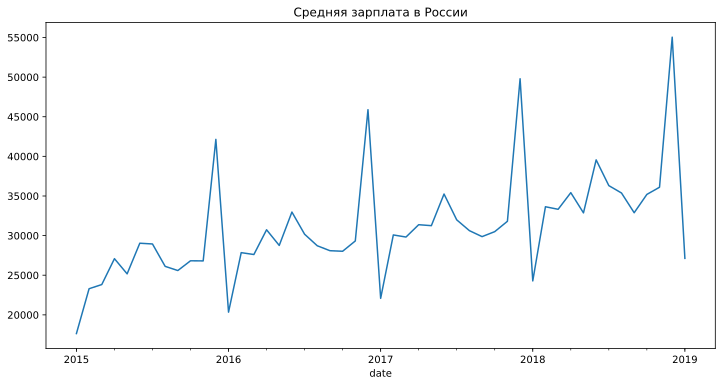

In [5]:
average_salary_russia = average_salary_russia.resample('M').mean()
average_salary_russia.plot(title='Средняя зарплата в России', figsize=(12, 6), legend = False)

Модель ARIMA (AutoregRessive Integrated Moving Average) – один из наиболее распространённых методов анализа и прогнозирования временных рядов. Эта модель позволяет обработать данные временного ряда, чтобы лучше понять этот ряд или предсказать его развитие.

In [6]:
# Определяем p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируем различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируем комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [7]:
# Подбираем оптимальные параметры
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(average_salary_russia, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1134.169674465878
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:834.6723856487008
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:685.3070765394506
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:nan
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:623.7005821157492
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:608.9237393160661
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:446.50055469058486
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:nan
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1086.366127803684
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:801.8949906686676
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:645.4996870255732
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1102.5505669231143
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:842.5336730403471
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:586.4064280913877
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:446.4910520645148
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:408.49196261625025
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:994.3589446899068
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1148.425414455174
SARIMA(0, 1, 0)x(

Согласно полученному выводу, SARIMAX(1, 1, 1)x(1, 1, 0, 12) являются оптимальными параметрами. Добавим оптимальные параметры в модель.

In [8]:
mod = sm.tsa.statespace.SARIMAX(average_salary_russia, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4242      0.300     -1.413      0.158      -1.013       0.164
ma.L1         -0.5260      0.233     -2.261      0.024      -0.982      -0.070
ar.S.L12       0.1139      0.127      0.899      0.369      -0.134       0.362
sigma2      8.646e+05   4.07e+05      2.123      0.034    6.64e+04    1.66e+06


Атрибут summary возвращает много информации, но мы сосредоточим наше внимание на таблице коэффициентов. Столбец coef определяет важность каждого параметра и его влияние на временной ряд. Столбец P>|z| сообщает значимость каждого параметра. Здесь вес (важность) каждого параметра p имеет достаточно большие значения, поэтому разумно сохранить в модели все параметры.

Визуализируем полученные результаты подбора параметров

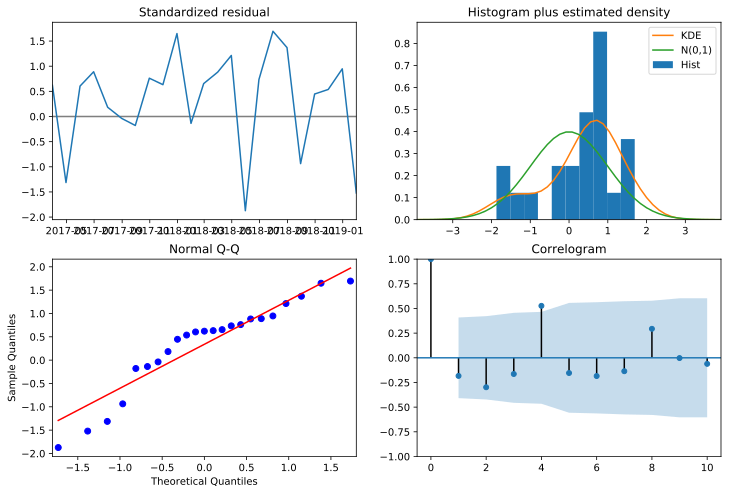

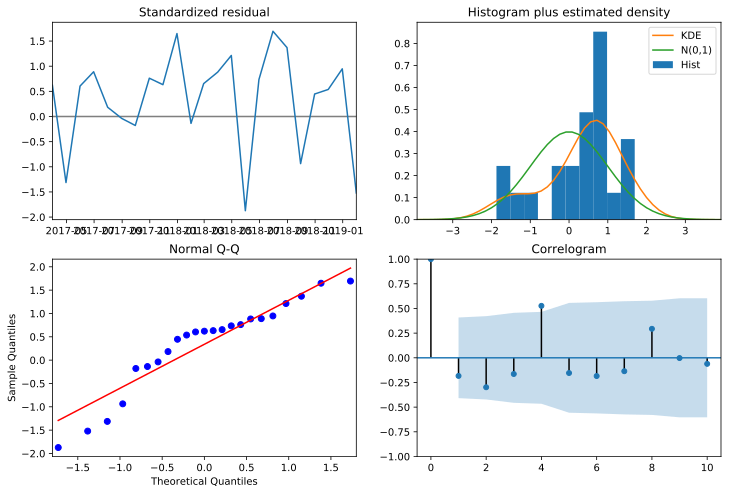

In [9]:
results.plot_diagnostics(figsize=(12, 8))

Эти графики позволяют сделать вывод о том, что выбранная модель (удовлетворительно) подходит для анализа и прогнозирования данных временных рядов.

Для дальнейшего прогноза временного ряда (средней зарплаты в России) нужно сравнить прогнозируемые значения с реальными значениями временного ряда, что поможет нам понять точность прогнозов. Атрибуты get_prediction () и conf_int () позволяют получать значения и интервалы для прогнозов временных рядов.

In [10]:
pred = results.get_prediction(dynamic=False)
pred_ci = pred.conf_int()

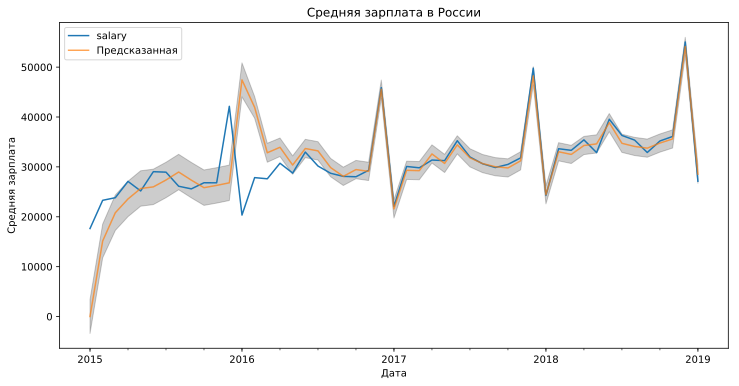

In [11]:
ax = average_salary_russia.plot(label='Фактическая', title='Средняя зарплата в России', figsize=(12, 6))
pred.predicted_mean.plot(ax=ax, label='Предсказанная', alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Дата')
ax.set_ylabel('Средняя зарплата')
plt.legend()
plt.show()

В целом, прогнозы соответствуют истинным значениям, демонстрируя общий тренд на увеличение. Теперь можно предсказать развитие средней зарплаты в России на ближайшие 10 лет (120 месяцев).

In [12]:
y_forecasted = pred.predicted_mean
y_truth = average_salary_russia
mse = ((y_forecasted - y_truth) ** 2).mean()

In [13]:
pred_dynamic = results.get_prediction(dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [14]:
# Получить прогноз на 120 шагов (месяцев) вперёд
pred_uc = results.get_forecast(steps=120)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

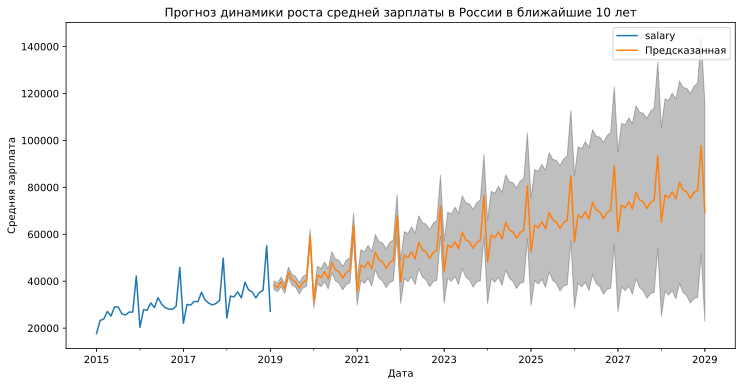

In [15]:
ax = average_salary_russia.plot(label='Фактическая', title='Прогноз динамики роста средней зарплаты в России в ближайшие 10 лет', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Предсказанная')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Дата')
ax.set_ylabel('Средняя зарплата')
plt.legend()
plt.show()

Как видно из графика, средняя зарплата в России в ближайшие 10 лет будет рости. Конечно, чем дальше строится прогноз, тем менее точны его значения. Это отражается на интервалах, генерируемых моделью (чем дальше прогноз, тем больше интервал).